In [1]:
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd

import pickle
import os

import matplotlib.ticker as mtick

In [2]:
# Specify the location of the weights of the pre-trained baseline model, h5 is for hdf, high dimensional data format 
# it is generally used to store multidimensional arrays
BASELINE_MODEL = "weights_rafdb/model_weights_1626211720.h5"

The pickle module implements binary protocols for serializing and de-serializing a Python object structure. “Pickling” is the process whereby a Python object hierarchy is converted into a byte stream, and “unpickling” is the inverse operation, whereby a byte stream (from a binary file or bytes-like object) is converted back into an object hierarchy. 

In [3]:
file = open("weights_rafdb/model_history_1626211720", "rb") #read binary
baseline_history = pickle.load(file) #loads python from a binary file
print(f"The keys of the dictionary : {baseline_history.keys()}") #['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr']
print(f"The values of an attribute (loss) : {baseline_history['loss']}")
print(f"The dimensions of an attribute (loss) : {len(baseline_history['loss'])}") #all are of 20 length only, each number indicates the training epoches

The keys of the dictionary : dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])
The values of an attribute (loss) : [1.4696846091189175, 1.0789363704599269, 0.908026170415011, 0.8170374295750283, 0.7589972326009236, 0.7044656795948507, 0.6563972480225596, 0.6221271203335462, 0.5889366481007874, 0.5629007877920936, 0.5324182177312683, 0.5139536742817704, 0.49130869913514175, 0.40525348130097644, 0.378723073316386, 0.3595358312485489, 0.35212184169175764, 0.3405177219040264, 0.3256947643441871, 0.32366310769226514]
The dimensions of an attribute (loss) : 20


## Graphs on the baseline model

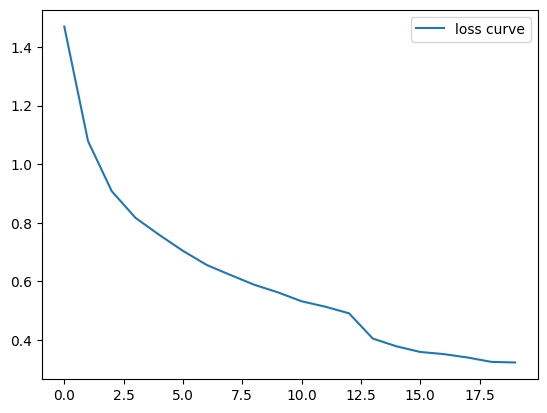

In [4]:
plt.plot(np.arange(0,20),baseline_history['loss'],label="loss curve")#loss curve
# plt.plot(baseline_history['accuracy'], np.arange(0,20),label="accuracy curve")#accuracy curve
plt.legend()

In [5]:
print("Baseline model performance:")
file = open("logs_rafdb/model_metrics_1626211720", "rb")
baseline_metrics = pickle.load(file)
print("Size:", baseline_metrics["size"])
print("Overall accuracy:", baseline_metrics["acc"])
print("Female accuracy:", baseline_metrics["f_acc"])
print("Male accuracy:", baseline_metrics["m_acc"])

Baseline model performance:
Size: 29801825
Overall accuracy: 0.8246414602346805
Female accuracy: 0.8333333333333334
Male accuracy: 0.8054443554843875


In [6]:
import os

def get_samples(method, parameter=None): 
    # Use os.listdir to list files in the directory
    logs = os.listdir('logs_rafdb')
    
    if method == "pruning": 
        relevant_logs = list(filter(lambda x: ("pruned_model_metrics_s" + str(parameter)) in x, logs))
    elif method == "pruning_and_quantisation": 
        relevant_logs = list(filter(lambda x: ("pruned_and_quantised_model_metrics_s" + str(parameter)) in x, logs))
    elif method == "clustering":
        relevant_logs = list(filter(lambda x: ("clustered_model_metrics_c" + str(parameter)) in x, logs))
    elif method == "clustering_and_quantisation":
        relevant_logs = list(filter(lambda x: ("clustered_and_quantised_model_metrics_c" + str(parameter)) in x, logs))
    elif method == "quantisation": 
        relevant_logs = list(filter(lambda x: x.startswith("q") and "quantised_model_metrics" in x, logs))
        
    all_metrics = []
    for log in relevant_logs: 
        with open("logs_rafdb/" + log, 'rb') as file:
            all_metrics.append(pickle.load(file))

    samples = {'size': [], 'acc': [], 'f_acc': [], 'm_acc': [], 'caucasian_acc': [], 'afamerican_acc': [], 
              'asian_acc': [], 'age0_acc': [], 'age1_acc': [], 'age2_acc': [], 'age3_acc': [], 'age4_acc': []}
    
    for metrics in all_metrics: 
        for key in samples: 
            samples[key].append(metrics[key])
                
    return samples


In [7]:
def get_results_for(method, parameter=None): 
    samples = get_samples(method, parameter)

    return {
        "mean": {key: sum(samples[key])/len(samples[key]) for key in samples}, 
        "sd": {key: np.std(samples[key]) for key in samples}
    }

# Quantisation 

**All features**
```'size',
'acc', => accuracy 
'f_acc', => female accuracy 
'm_acc', =>male accuracy 
'caucasian_acc' 
'afamerican_acc',
'asian_acc',
'age0_acc',
'age1_acc',
'age2_acc',
'age3_acc',
'age4_acc'```

age (with subjects being assigned to one of 5 age
groups - 0-3, 4-19, 20-39, 40-69 and 70+).

In [8]:
quant_results = get_results_for("quantisation")
quant_results

{'mean': {'size': 6568174.0,
  'acc': 0.8246414602346805,
  'f_acc': 0.8320987654320988,
  'm_acc': 0.8070456365092074,
  'caucasian_acc': 0.8192258613356018,
  'afamerican_acc': 0.8675213675213675,
  'asian_acc': 0.8302277432712215,
  'age0_acc': 0.8996960486322189,
  'age1_acc': 0.8292181069958847,
  'age2_acc': 0.8050541516245487,
  'age3_acc': 0.8565737051792829,
  'age4_acc': 0.7078651685393258},
 'sd': {'size': 0.0,
  'acc': 0.0,
  'f_acc': 0.0,
  'm_acc': 0.0,
  'caucasian_acc': 0.0,
  'afamerican_acc': 0.0,
  'asian_acc': 0.0,
  'age0_acc': 0.0,
  'age1_acc': 0.0,
  'age2_acc': 0.0,
  'age3_acc': 0.0,
  'age4_acc': 0.0}}

In [9]:
def graph_plotter(attribute):    
    fg = plt.figure(figsize=(6, 2))  # Create a new figure for each plot
    ax = fg.add_subplot(1, 1, 1)

    plt.tick_params(labelsize=14)

    models = ['Baseline model', 'Quantised model']
    y_pos = np.arange(2)
    performance = [baseline_metrics[attribute], quant_results["mean"][attribute]]
    error = [0, quant_results["sd"][attribute]]

    ax.barh(y_pos, performance, xerr=error, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(models)
    ax.invert_yaxis()
    ax.set_xlabel(str(attribute), size=14)

    # Apply the custom formatting only if the attribute is "size"
    if attribute == "size":
        def numfmt(x, pos):  # Custom formatter: convert bytes to MB
            return '{}'.format(x // 1000000)

        ax.set_xticks(np.arange(0, 32000000, step=4000000))
        yfmt = mtick.FuncFormatter(numfmt)
        ax.xaxis.set_major_formatter(yfmt)

    # Save each figure with a unique filename
    plt.savefig(f"figures/quantisation_results_{attribute}.svg")

    # Show the plot in notebook
    plt.show()  # Ensure the plot is rendered in the notebook

    # Clear the figure after displaying to avoid overlap
    plt.clf()


In [10]:
baseline_metrics
#these are in ordder of their importance 

{'size': 29801825,
 'acc': 0.8246414602346805,
 'f_acc': 0.8333333333333334,
 'm_acc': 0.8054443554843875,
 'caucasian_acc': 0.8192258613356018,
 'afamerican_acc': 0.8675213675213675,
 'asian_acc': 0.8302277432712215,
 'age0_acc': 0.8996960486322189,
 'age1_acc': 0.8292181069958847,
 'age2_acc': 0.8044524669073405,
 'age3_acc': 0.8585657370517928,
 'age4_acc': 0.7078651685393258}

In [11]:
# # Iterate through all attributes and generate individual plots
# for i in quant_results["mean"].keys():
#     graph_plotter(i)
#     plt.show()
df = pd.DataFrame({"Attribute":quant_results["mean"].keys(),
                   "Value_Quant":np.array(quant_results["mean"].values()),
                   "Value_baseline":np.array(baseline_metrics.values())})
df["gap"] = df["Value_baseline"]-df["Value_Quant"]
df["gap_division"] = (df["Value_baseline"] / df["Value_Quant"]).round().astype(int)
df
#note, size is in bytes here 

,Attribute,Value_Quant,Value_baseline,gap,gap_division
0,size,6568174.0,29801825,23233651.0,4
1,acc,0.824641,0.824641,0.0,1
2,f_acc,0.832099,0.833333,0.001235,1
3,m_acc,0.807046,0.805444,-0.001601,0
4,caucasian_acc,0.819226,0.819226,0.0,1
5,afamerican_acc,0.867521,0.867521,0.0,1
6,asian_acc,0.830228,0.830228,0.0,1
7,age0_acc,0.899696,0.899696,0.0,1
8,age1_acc,0.829218,0.829218,0.0,1
9,age2_acc,0.805054,0.804452,-0.000602,0


## Pruning 

How to check gap metric for pruning?

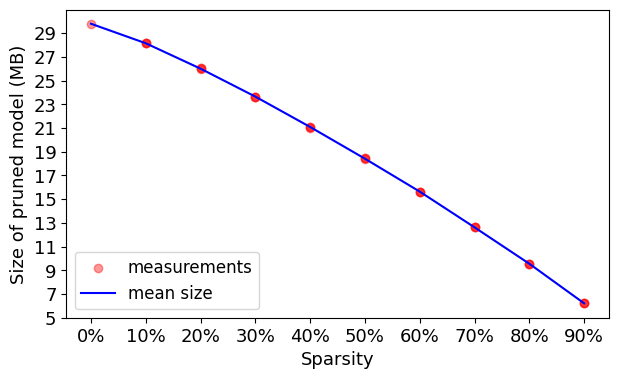

<Figure size 640x480 with 0 Axes>

In [12]:
sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]
size_points = []

size_means = [get_results_for("pruning", n)["mean"]["size"] for n in sparsities]
size_sds = [get_results_for("pruning", n)["sd"]["size"] for n in sparsities]

for n in sparsities:
    size_points += [(n, size) for size in (get_samples("pruning", n)["size"])]
    
sparsities = [0] + sparsities 
size_means = [baseline_metrics["size"]] + size_means
size_sds = [0] + size_sds
size_points.append((0, baseline_metrics["size"]))

size_means = np.array(size_means)
size_sds = np.array(size_sds)

x, y = list(zip(*size_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(sparsities, size_means, c="blue", label="mean size")
plt.fill_between(sparsities, size_means - size_sds, size_means + size_sds,
                 color='grey', alpha=0.15)
plt.xticks(sparsities, sparsities)
plt.xlabel("Sparsity", size=13)
plt.ylabel("Size of pruned model (MB)", size=13)

plt.legend(loc="lower left", prop={'size': 12})

def numfmt(x, pos): # your custom formatter function: divide by 100.0
    s = '{}'.format(x // 1000000)
    return s

yfmt = mtick.FuncFormatter(numfmt)    # create your custom formatter function
ax.yaxis.set_major_formatter(yfmt)
ax.set_yticks(np.arange(5000000, 30000000, step=2000000))

xticks = mtick.PercentFormatter()
ax.xaxis.set_major_formatter(xticks)

plt.show()
plt.savefig("figures_rafdb/pruning_size.svg")

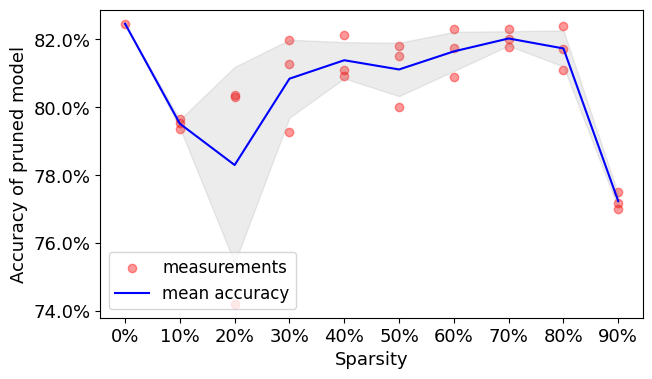

In [13]:
sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]
acc_points = []

acc_means = [get_results_for("pruning", n)["mean"]["acc"] for n in sparsities]
acc_sds = [get_results_for("pruning", n)["sd"]["acc"] for n in sparsities]

for n in sparsities:
    acc_points += [(n, size) for size in (get_samples("pruning", n)["acc"])]
    
sparsities = [0] + sparsities 
acc_means = [baseline_metrics["acc"]] + acc_means
acc_sds = [0] + acc_sds
acc_points.append((0, baseline_metrics["acc"]))

acc_means = np.array(acc_means)
acc_sds = np.array(acc_sds)

x, y = list(zip(*acc_points))

fig = plt.figure(1, (7,4))
ax = fig.add_subplot(1,1,1)

plt.tick_params(labelsize=13)

plt.scatter(x, y, c="red", alpha=0.4, label="measurements")
plt.plot(sparsities, acc_means, c="blue", label="mean accuracy")
plt.fill_between(sparsities, acc_means - acc_sds, acc_means + acc_sds,
                 color='grey', alpha=0.15)
plt.xticks(sparsities, sparsities)
plt.xlabel("Sparsity", size=13)
plt.ylabel("Accuracy of pruned model", size=13)

plt.legend(loc="lower left", prop={'size': 12})

yticks = mtick.PercentFormatter(1.0)
ax.yaxis.set_major_formatter(yticks)

xticks = mtick.PercentFormatter()
ax.xaxis.set_major_formatter(xticks)

plt.savefig("figures_rafdb/pruning_acc.svg")

### Dataframes

In [14]:
sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]

In [15]:
acc_means = [get_results_for("pruning", n)["mean"]["acc"] for n in sparsities]
size_means = [get_results_for("pruning", n)["mean"]["size"] for n in sparsities]
f_acc_means = [get_results_for("pruning", n)["mean"]["f_acc"] for n in sparsities]
m_acc_means = [get_results_for("pruning", n)["mean"]["m_acc"] for n in sparsities]

In [16]:
get_results_for("pruning", 10)

{'mean': {'size': 28153449.666666668,
  'acc': 0.7951977401129944,
  'f_acc': 0.8004115226337448,
  'm_acc': 0.7864958633573526,
  'caucasian_acc': 0.7900184318729618,
  'afamerican_acc': 0.8190883190883191,
  'asian_acc': 0.8088336783988958,
  'age0_acc': 0.8257345491388044,
  'age1_acc': 0.8264746227709191,
  'age2_acc': 0.7853991175290814,
  'age3_acc': 0.7988047808764941,
  'age4_acc': 0.6741573033707865},
 'sd': {'size': 356.2904557925863,
  'acc': 0.0012000609536274812,
  'f_acc': 0.002036933114529118,
  'm_acc': 0.003089361329807945,
  'caucasian_acc': 0.0038255317065736877,
  'afamerican_acc': 0.017905705256376855,
  'asian_acc': 0.00850850794060589,
  'age0_acc': 0.00939576341995514,
  'age1_acc': 0.006360506512685655,
  'age2_acc': 0.001985458270479688,
  'age3_acc': 0.012909842028700958,
  'age4_acc': 0.015890040026663974}}

In [17]:
df_pruning_means = pd.DataFrame({"Sparsities":sparsities,"Accuracy":acc_means,"size_decline":size_means,"female_acc":f_acc_means,"male_acc":m_acc_means})
df_pruning_means

,Sparsities,Accuracy,size_decline,female_acc,male_acc
0,10,0.795198,2.815345e+07,0.800412,0.786496
1,20,0.783029,2.601093e+07,0.787243,0.774753
2,30,0.808453,2.365261e+07,0.813786,0.796904
3,40,0.813885,2.109197e+07,0.819547,0.799306
4,50,0.811169,1.841581e+07,0.818930,0.795837
5,60,0.816493,1.563958e+07,0.825309,0.798239
6,70,0.820296,1.262534e+07,0.824074,0.806245
7,80,0.817362,9.554116e+06,0.822840,0.801174
8,90,0.772382,6.214969e+06,0.770988,0.768348


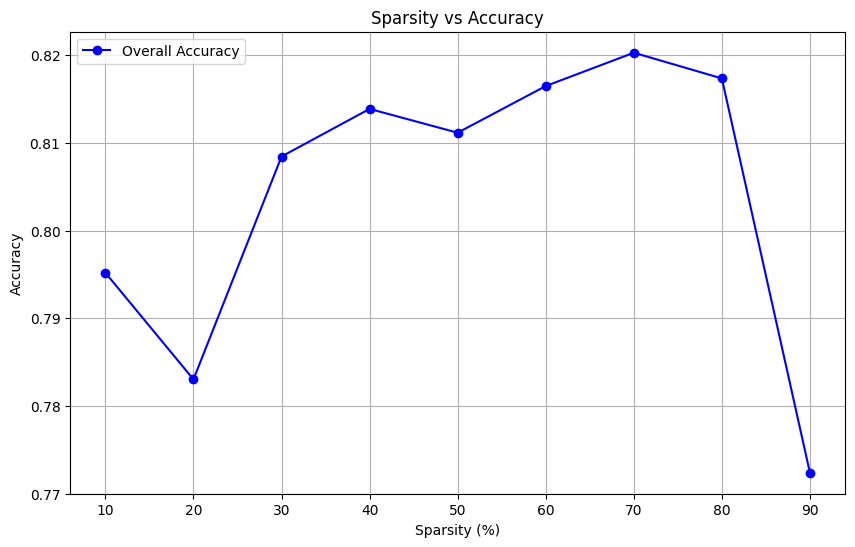

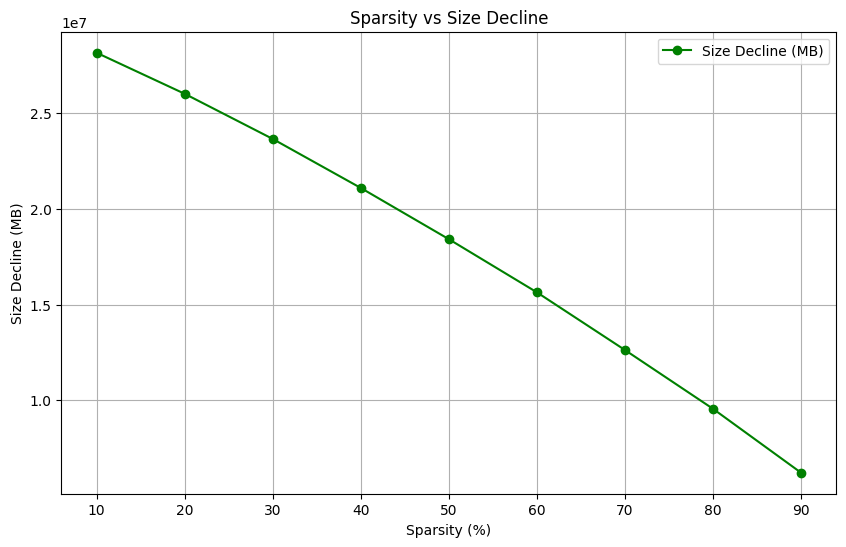

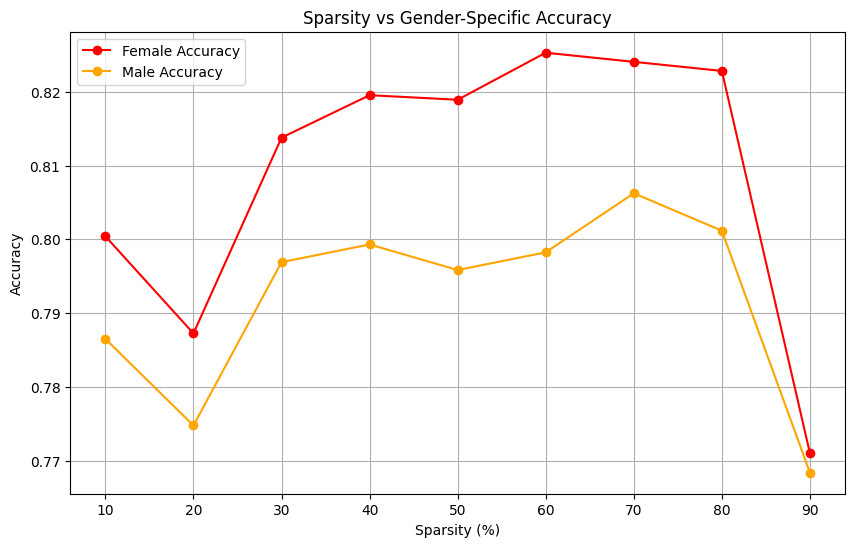

In [18]:
# Plot 1: Sparsity vs Accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_pruning_means["Sparsities"], df_pruning_means["Accuracy"], marker='o', color='blue', label='Overall Accuracy')
plt.xlabel("Sparsity (%)")
plt.ylabel("Accuracy")
plt.title("Sparsity vs Accuracy")
plt.grid(True)
plt.legend()
plt.show()

# Plot 2: Sparsity vs Size Decline
plt.figure(figsize=(10, 6))
plt.plot(df_pruning_means["Sparsities"], df_pruning_means["size_decline"], marker='o', color='green', label='Size Decline (MB)')
plt.xlabel("Sparsity (%)")
plt.ylabel("Size Decline (MB)")
plt.title("Sparsity vs Size Decline")
plt.grid(True)
plt.legend()
plt.show()

# Plot 3: Sparsity vs Female and Male Accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_pruning_means["Sparsities"], df_pruning_means["female_acc"], marker='o', color='red', label='Female Accuracy')
plt.plot(df_pruning_means["Sparsities"], df_pruning_means["male_acc"], marker='o', color='orange', label='Male Accuracy')
plt.xlabel("Sparsity (%)")
plt.ylabel("Accuracy")
plt.title("Sparsity vs Gender-Specific Accuracy")
plt.grid(True)
plt.legend()
plt.show()

In [19]:
acc_std = [get_results_for("pruning", n)["sd"]["acc"] for n in sparsities]
size_std = [get_results_for("pruning", n)["sd"]["size"] for n in sparsities]
f_acc_std = [get_results_for("pruning", n)["sd"]["f_acc"] for n in sparsities]
m_acc_std = [get_results_for("pruning", n)["sd"]["m_acc"] for n in sparsities]

In [20]:
df_pruning_std = pd.DataFrame({"Sparsities":sparsities,"Accuracy":acc_std,"size_decline":size_std,"female_acc":f_acc_std,"male_acc":m_acc_std})
df_pruning_std

,Sparsities,Accuracy,size_decline,female_acc,male_acc
0,10,0.001200,356.290456,0.002037,0.003089
1,20,0.028888,24693.457181,0.028091,0.031598
2,30,0.011485,679.952940,0.013714,0.011272
3,40,0.005343,34810.790256,0.008907,0.002296
4,50,0.007851,39875.865235,0.008588,0.012523
5,60,0.005763,1212.519965,0.004000,0.009893
6,70,0.002135,838.694621,0.002520,0.004935
7,80,0.005325,21613.795291,0.009616,0.001997
8,90,0.002033,1108.076111,0.003528,0.000377


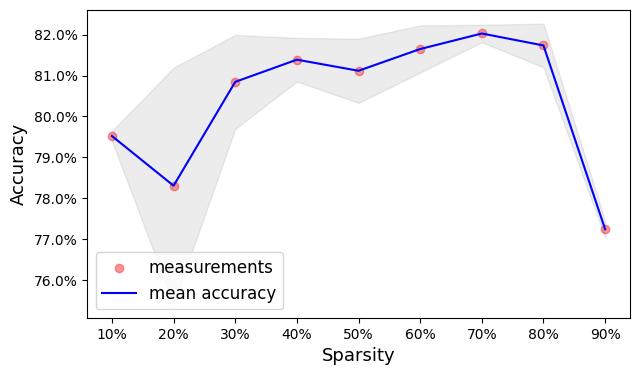

In [21]:
# Function to plot accuracy vs. sparsity with error bars and scatter points
def plot_accuracy_vs_sparsity(df_means, df_sds, attribute, xlabel="Sparsity", ylabel="Accuracy"):
    sparsities = df_means['Sparsities'].values
    means = df_means[attribute].values
    sds = df_sds[attribute].values
    
    fig, ax = plt.subplots(figsize=(7, 4))

    # Scatter plot for individual measurements
    plt.scatter(sparsities, means, color="red", alpha=0.4, label="measurements")

    # Line plot for mean accuracy
    plt.plot(sparsities, means, color="blue", label="mean accuracy")

    # Error bars for standard deviation
    plt.fill_between(sparsities, means - sds, means + sds, color='grey', alpha=0.15)

    # Formatting the plot
    plt.xticks(sparsities, sparsities)
    plt.xlabel(xlabel, size=13)
    plt.ylabel(ylabel, size=13)
    plt.legend(loc="lower left", prop={'size': 12})

    # Format y-axis as percentages
    yticks = mtick.PercentFormatter(1.0)
    ax.yaxis.set_major_formatter(yticks)

    # Optional: x-axis formatting if you want percentages (remove if unnecessary)
    xticks = mtick.PercentFormatter()
    ax.xaxis.set_major_formatter(xticks)

    # Save the plot
    plt.savefig(f"figures/{attribute}_vs_sparsity.svg")

    # Show the plot
    plt.show()

# Example plotting for "Accuracy" column
plot_accuracy_vs_sparsity(df_pruning_means, df_pruning_std, "Accuracy")


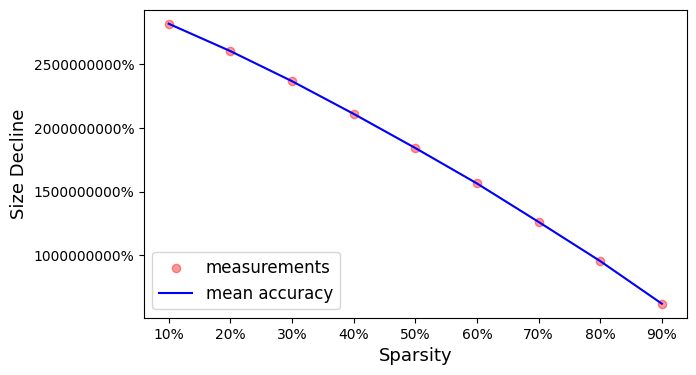

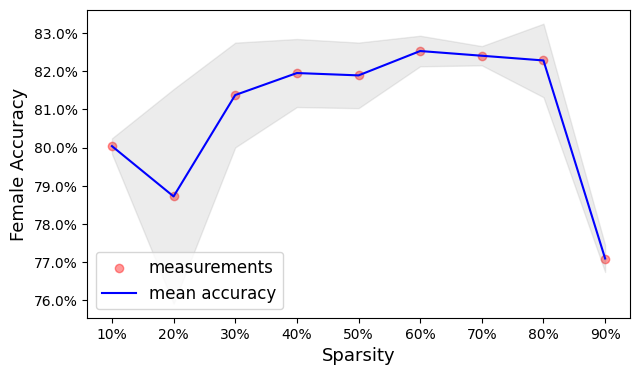

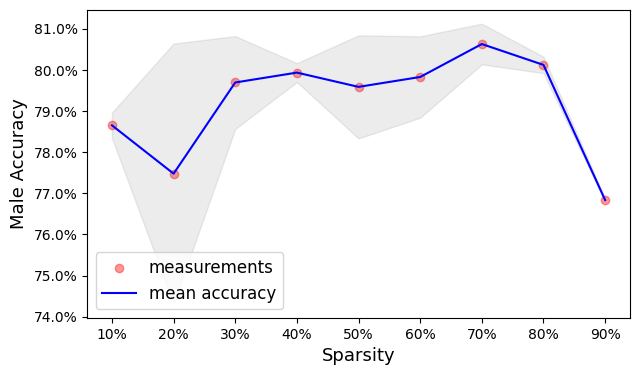

In [22]:
# Plot for size decline
plot_accuracy_vs_sparsity(df_pruning_means, df_pruning_std, "size_decline", xlabel="Sparsity", ylabel="Size Decline")

# Plot for female accuracy
plot_accuracy_vs_sparsity(df_pruning_means, df_pruning_std, "female_acc", xlabel="Sparsity", ylabel="Female Accuracy")

# Plot for male accuracy
plot_accuracy_vs_sparsity(df_pruning_means, df_pruning_std, "male_acc", xlabel="Sparsity", ylabel="Male Accuracy")


## Gender Fairness

In [23]:
results = [["baseline", baseline_metrics["size"], baseline_metrics["acc"], baseline_metrics["f_acc"], baseline_metrics["m_acc"]]] 

sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for n in sparsities: 
    pr_res = [get_results_for("pruning", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc"]]
    pr_res = ["pruning @ " + str(n)] + pr_res
    pr_q_res = [get_results_for("pruning_and_quantisation", n)["mean"][key] for key in ["size", "acc", "f_acc", "m_acc", ]]
    pr_q_res = ["pruning + quantisation @ " + str(n)] + pr_q_res
    
    results.append(pr_res)
    results.append(pr_q_res)

In [24]:
male_accuracy = [lst[-1] for lst in results]
female_accuracy = [lst[-2] for lst in results]
overall_accuracy = [lst[-3] for lst in results]
model_sizes = [lst[1] for lst in results]
methods=[lst[0] for lst in results]

In [25]:
df = pd.DataFrame(results, columns=["Method", "Model size", "Overall accuracy", "Female accuracy", "Male accuracy"])
baseline_model_size = df["Model size"][0]
df["size gap"] = baseline_model_size/df["Model size"]
df

,Method,Model size,Overall accuracy,Female accuracy,Male accuracy,size gap
0,baseline,2.980182e+07,0.824641,0.833333,0.805444,1.000000
1,pruning @ 10,2.815345e+07,0.795198,0.800412,0.786496,1.058550
2,pruning + quantisation @ 10,6.444067e+06,0.795415,0.800617,0.786229,4.624692
3,pruning @ 20,2.601093e+07,0.783029,0.787243,0.774753,1.145743
4,pruning + quantisation @ 20,6.293085e+06,0.783246,0.786831,0.775821,4.735647
5,pruning @ 30,2.365261e+07,0.808453,0.813786,0.796904,1.259981
6,pruning + quantisation @ 30,6.035305e+06,0.808561,0.814403,0.795837,4.937916
7,pruning @ 40,2.109197e+07,0.813885,0.819547,0.799306,1.412947
8,pruning + quantisation @ 40,5.554811e+06,0.814646,0.820576,0.799840,5.365048
9,pruning @ 50,1.841581e+07,0.811169,0.818930,0.795837,1.618274


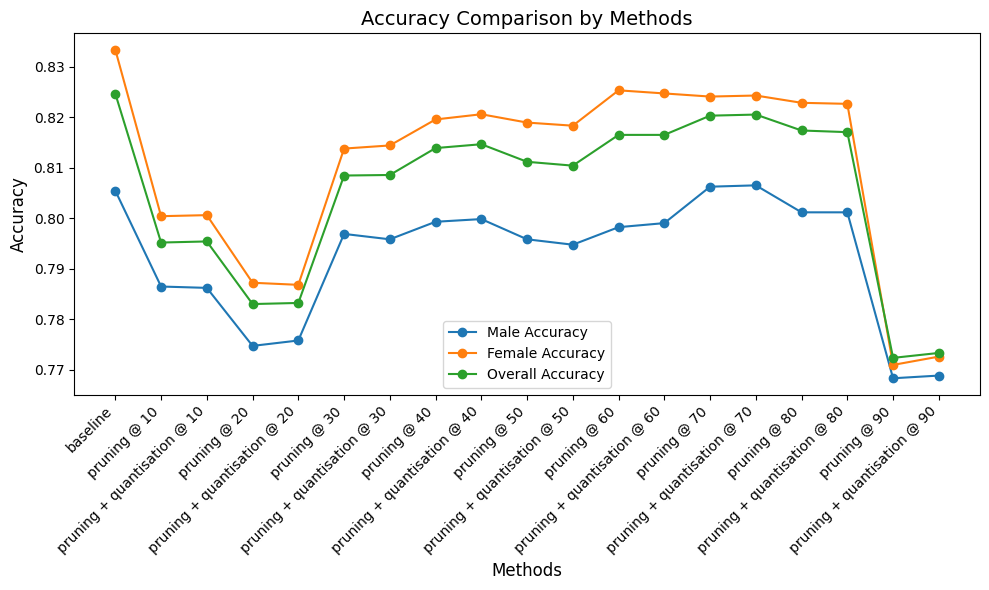

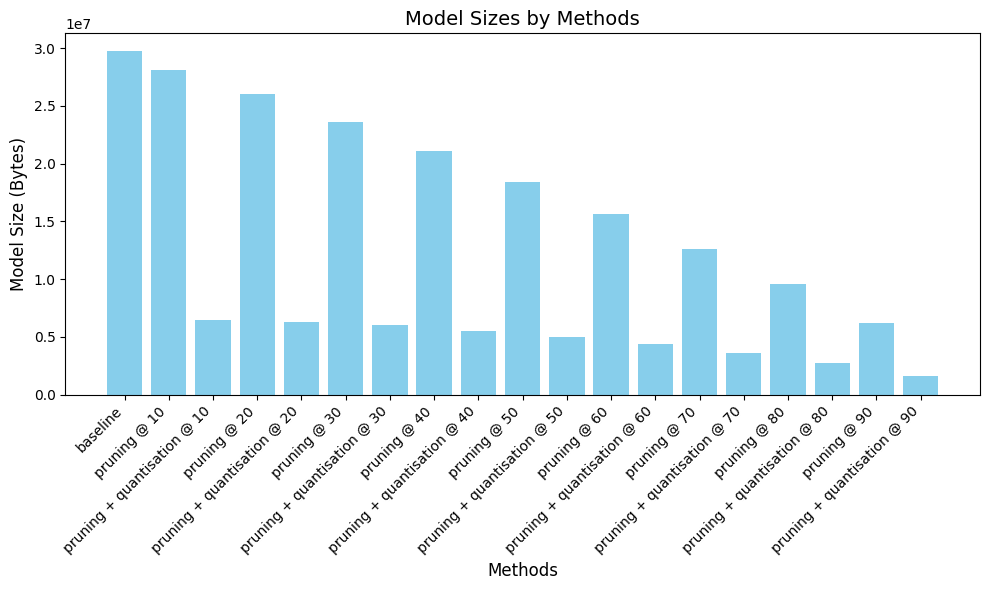

In [26]:
# Function to plot accuracies
def plot_accuracies(male_acc, female_acc, overall_acc, methods):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(methods, male_acc, label="Male Accuracy", marker='o')
    ax.plot(methods, female_acc, label="Female Accuracy", marker='o')
    ax.plot(methods, overall_acc, label="Overall Accuracy", marker='o')

    ax.set_xlabel("Methods", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title("Accuracy Comparison by Methods", fontsize=14)
    ax.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Function to plot model sizes
def plot_model_sizes(model_sizes, methods):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(methods, model_sizes, color='skyblue')

    ax.set_xlabel("Methods", fontsize=12)
    ax.set_ylabel("Model Size (Bytes)", fontsize=12)
    ax.set_title("Model Sizes by Methods", fontsize=14)
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


# Call the functions to generate the plots
plot_accuracies(male_accuracy, female_accuracy, overall_accuracy, methods)
plot_model_sizes(model_sizes, methods)


### Race fairness

In [27]:
results = [[
    "baseline", 
    baseline_metrics["size"], 
    baseline_metrics["acc"], 
    baseline_metrics["caucasian_acc"], 
    baseline_metrics["afamerican_acc"], 
    baseline_metrics["asian_acc"]
]] 

sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for n in sparsities: 
    pr_res = [get_results_for("pruning", n)["mean"][key] for key in [
        "size", "acc", "caucasian_acc", "afamerican_acc", "asian_acc"
    ]]
    pr_res = ["pruning @ " + str(n)] + pr_res
    pr_q_res = [get_results_for("pruning_and_quantisation", n)["mean"][key] for key in [
        "size", "acc", "caucasian_acc", "afamerican_acc", "asian_acc" 
    ]]
    pr_q_res = ["pruning + quantisation @ " + str(n)] + pr_q_res
    
    results.append(pr_res)
    results.append(pr_q_res)

In [28]:
asian_acc = [lst[-1] for lst in results]
afro_acc = [lst[-2] for lst in results]
cauc_acc = [lst[-3] for lst in results]
overall_acc = [lst[-4] for lst in results]
methods=[lst[0] for lst in results]

In [29]:
df = pd.DataFrame(results, columns=[
    "Method", "Model size", "Overall accuracy", "Caucasian accuracy", "African American accuracy", "Asian accuracy"
])
df

,Method,Model size,Overall accuracy,Caucasian accuracy,African American accuracy,Asian accuracy
0,baseline,2.980182e+07,0.824641,0.819226,0.867521,0.830228
1,pruning @ 10,2.815345e+07,0.795198,0.790018,0.819088,0.808834
2,pruning + quantisation @ 10,6.444067e+06,0.795415,0.790586,0.819088,0.807453
3,pruning @ 20,2.601093e+07,0.783029,0.781086,0.801994,0.783299
4,pruning + quantisation @ 20,6.293085e+06,0.783246,0.781653,0.801994,0.781919
5,pruning @ 30,2.365261e+07,0.808453,0.804480,0.843305,0.810904
6,pruning + quantisation @ 30,6.035305e+06,0.808561,0.805047,0.843305,0.808834
7,pruning @ 40,2.109197e+07,0.813885,0.809726,0.840456,0.821256
8,pruning + quantisation @ 40,5.554811e+06,0.814646,0.810577,0.840456,0.821946
9,pruning @ 50,1.841581e+07,0.811169,0.808592,0.843305,0.808144


In [30]:
def plot_accuracies(asian_acc, afro_acc, cauc_acc, overall_acc, methods):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(methods, asian_acc, label="Asian Accuracy", marker='o')
    ax.plot(methods, afro_acc, label="African American Accuracy", marker='o')
    ax.plot(methods, cauc_acc, label="Caucassian Accuracy", marker='o')
    ax.plot(methods, overall_acc, label="Overall Accuracy", marker='o')

    ax.set_xlabel("Methods", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title("Accuracy Comparison by Methods", fontsize=14)
    ax.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

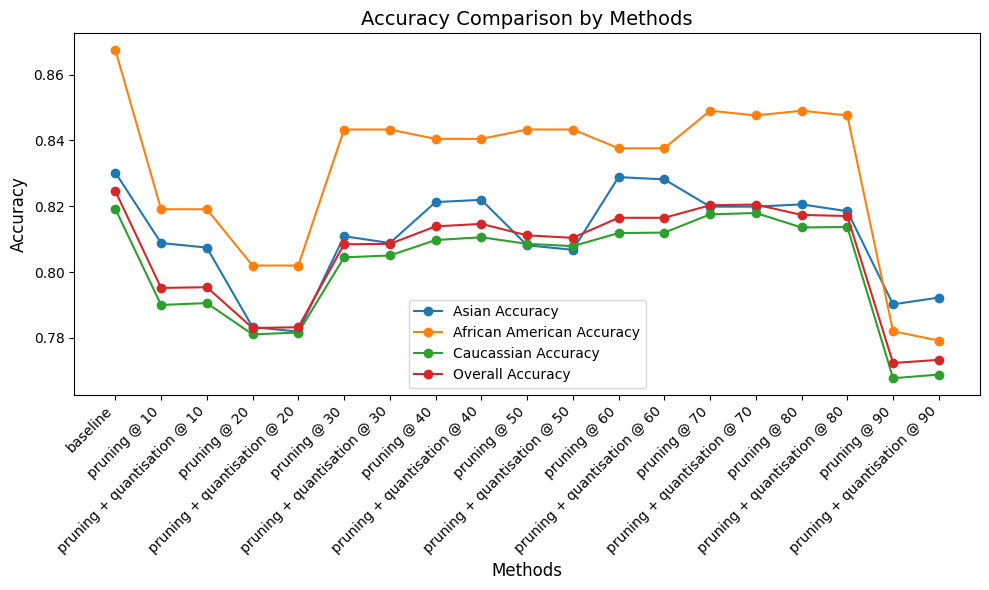

In [31]:
plot_accuracies(asian_acc, afro_acc, cauc_acc, overall_acc, methods)

### Age fairness 

In [32]:
results = [[
    "baseline", 
    baseline_metrics["size"], 
    baseline_metrics["acc"], 
    baseline_metrics["age0_acc"], 
    baseline_metrics["age1_acc"], 
    baseline_metrics["age2_acc"], 
    baseline_metrics["age3_acc"],
    baseline_metrics["age4_acc"]
]] 

sparsities = [10, 20, 30, 40, 50, 60, 70, 80, 90]

for n in sparsities: 
    pr_res = [get_results_for("pruning", n)["mean"][key] for key in [
        "size", "acc", "age0_acc", "age1_acc", "age2_acc", "age3_acc", "age4_acc"
    ]]
    pr_res = ["pruning @ " + str(n)] + pr_res
    pr_q_res = [get_results_for("pruning_and_quantisation", n)["mean"][key] for key in [
        "size", "acc", "age0_acc", "age1_acc", "age2_acc", "age3_acc", "age4_acc"
    ]]
    pr_q_res = ["pruning + quantisation @ " + str(n)] + pr_q_res
    
    results.append(pr_res)
    results.append(pr_q_res)

In [34]:
age_4 = [lst[-1] for lst in results]
age_3 = [lst[-2] for lst in results]
age_2 = [lst[-3] for lst in results]
age_1 = [lst[-4] for lst in results]
age_0=[lst[-5] for lst in results]

In [33]:
df = pd.DataFrame(results, columns=[
    "Method", "Model size", "Overall accuracy", "Age0 acc", "Age1 acc", "Age2 acc", "Age3 acc", "Age4 acc"
])
df

,Method,Model size,Overall accuracy,Age0 acc,Age1 acc,Age2 acc,Age3 acc,Age4 acc
0,baseline,2.980182e+07,0.824641,0.899696,0.829218,0.804452,0.858566,0.707865
1,pruning @ 10,2.815345e+07,0.795198,0.825735,0.826475,0.785399,0.798805,0.674157
2,pruning + quantisation @ 10,6.444067e+06,0.795415,0.826748,0.825789,0.785800,0.799469,0.670412
3,pruning @ 20,2.601093e+07,0.783029,0.821682,0.793553,0.774769,0.793493,0.677903
4,pruning + quantisation @ 20,6.293085e+06,0.783246,0.820669,0.794925,0.774569,0.795485,0.674157
5,pruning @ 30,2.365261e+07,0.808453,0.855117,0.827160,0.789009,0.843293,0.700375
6,pruning + quantisation @ 30,6.035305e+06,0.808561,0.857143,0.827846,0.789210,0.841965,0.696629
7,pruning @ 40,2.109197e+07,0.813885,0.883485,0.827846,0.795628,0.837981,0.685393
8,pruning + quantisation @ 40,5.554811e+06,0.814646,0.883485,0.827846,0.796831,0.838645,0.685393
9,pruning @ 50,1.841581e+07,0.811169,0.870314,0.828532,0.791817,0.835989,0.719101


In [35]:
def plot_accuracies(age_0,age_1,age_2,age_3,age_4,overall_acc,methods):
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.plot(methods, age_0, label="Age 0 ()", marker='o')
    ax.plot(methods, age_1, label="Age 1 ()", marker='o')
    ax.plot(methods, age_2, label="Age 2 ()", marker='o')
    ax.plot(methods, age_3, label="Age 3 ()", marker='o')
    ax.plot(methods, age_4, label="Age 4 ()", marker='o')
    ax.plot(methods, overall_acc, label="Overall Accuracy", marker='o')


    ax.set_xlabel("Methods", fontsize=12)
    ax.set_ylabel("Accuracy", fontsize=12)
    ax.set_title("Accuracy Comparison by Methods", fontsize=14)
    ax.legend()
    
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

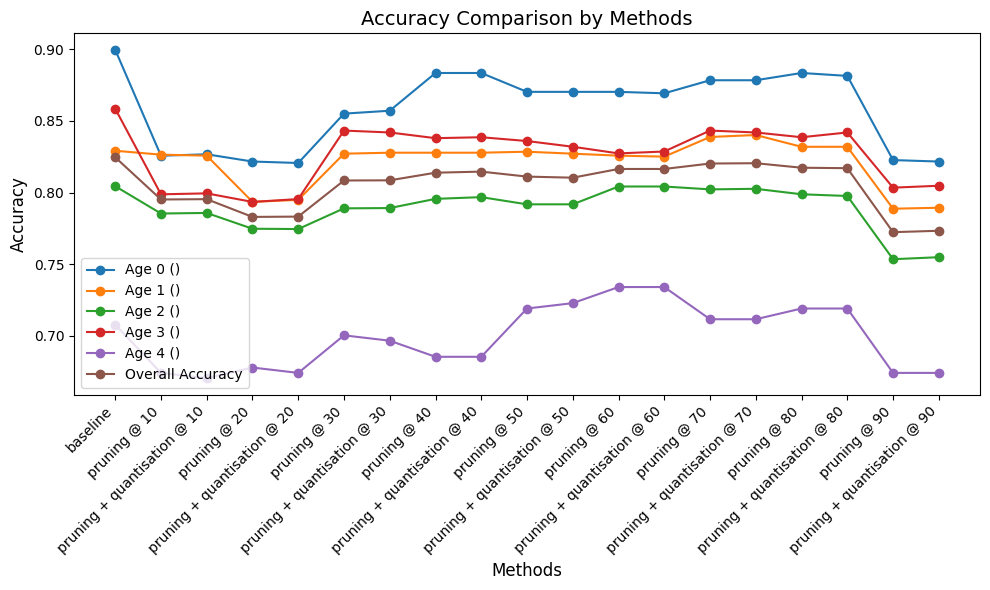

In [37]:
plot_accuracies(age_0,age_1,age_2,age_3,age_4,overall_acc,methods)

## Clustering

(yet to do, waiting for feedback on the previous plots)